In [1411]:
import numpy as np
import scipy as sp
from dataclasses import dataclass
from typing import List
from IPython.display import Math, display
import matplotlib.pyplot as plt

In [1412]:
EXTRA_SAMPLE_SIZE = 1000
SAVE_PLOTS = False
FINITE_DIFFERENCE_APPROXIMATION_STEP_SIZE = 1e-6

In [1413]:
A_ = 1
D_ = 4
n_ = 1000
# m_ = 1e4
m_ = 1e1

In [1414]:
def generateValue(n=1):
    match A_:
        case 0:
            return sp.stats.uniform.rvs(size=n)
        case 1:
            return np.sqrt(sp.stats.uniform.rvs(size=n))
        case 2:
            return 1 - np.sqrt(sp.stats.uniform.rvs(size=n))

def metric(nu, p):
    nu = np.array(nu)
    p  = np.array(p)
    match D_:
        case 1:
            return 1/n_ * np.max(np.abs(nu - n_ * p))
        case 2:
            return 1/n_ * np.sum(np.abs(nu - n_ * p))
        case 3:
            return 1/n_ * np.sqrt(np.sum((nu - n_ * p)**2))
        case 4:
            return np.sum((np.abs(nu - n_ * p))/(n_ * p))
        case 5:
            return np.sum((nu - n_ * p)**2/(n_ * p * (n_ - n_ * p)))

m_ = int(m_)

In [1415]:
a_ = 0
b_ = 1

In [1416]:
@dataclass
class Sample:
    n:                 int
    min:               float
    max:               float
    range:             float
    l:                 float
    h:                 float
    int_boundaries:    List[float]
    intervals:         List[float]
    mid_ranges:        List[float]
    freqs:             List[float]
    rel_freqs:         List[float]
    rel_freqs_density: List[float]

    def __str__(self) -> str:
        str_: str = f'n: {self.n}\n'                                              \
                    f'min: {self.min}     max: {self.max}\n'                      \
                    f'range: {self.range}\n'                                      \
                    f'l: {self.l}\n'                                              \
                    f'h: {self.h}\n'                                              \
                    f'interval boundaries: {self.int_boundaries}\n'               \
                    f'intervals: {self.intervals}\n'                              \
                    f'intervals\' midpoints: {self.mid_ranges}\n'                 \
                    f'frequencies: {self.freqs}\n'                                \
                    f'relative frequencies: {self.rel_freqs}\n'                   \
                    f'relative frequencies\' density: {self.rel_freqs_density}\n' \
                    
        # str_ += '-'*100 + '\n'
        
        # space_ = ' ' * 5
        # for i in range(self.l):
        #     str_ += f'{self.intervals[i]}{space_}{self.freqs[i]}{space_}{self.rel_freqs[i]}{space_}{self.rel_freqs_density[i]}\n'
        return str_

In [1417]:
class CDM:
    def __init__(self, h):
        self.h = h
    
    def diff(self, f, x):
        numerator = f(x + self.h) - f(x - self.h)
        denominator = 2 * self.h

        return numerator / denominator

In [1418]:
cdm_ = CDM(h=FINITE_DIFFERENCE_APPROXIMATION_STEP_SIZE)

In [1419]:
def decorate_plot(ax, x_ticks, xname, yname, loc=(-0.025, -0.3)):
    SIZE_TICKS = 10

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # axis names
    ax.set_xlabel(xname, fontsize=15)
    ax.xaxis.set_label_coords(0.98, 0.05)

    ax.set_ylabel(yname, rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(0.025, 0.95)

    ax.set_xticks(x_ticks)

    # Adjust the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=SIZE_TICKS)

    plt.legend(fontsize=10, loc=loc)

    # Update font settings
    plt.rcParams.update({'font.family': 'serif', 'font.size': 12})

    # Adjust layout
    plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


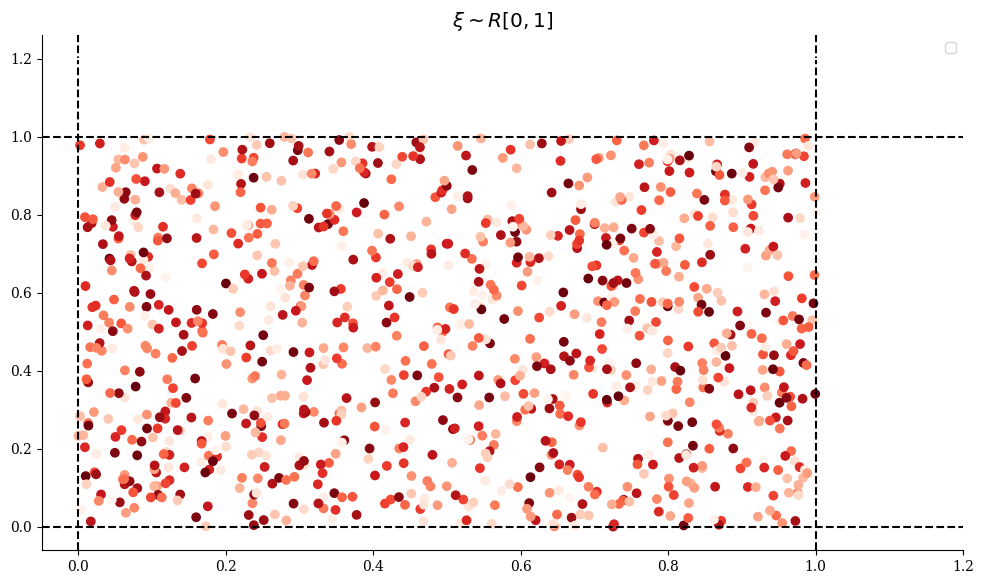

In [1420]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    step = interval_size/5

    x_values = [sp.stats.uniform.rvs() for _ in range(EXTRA_SAMPLE_SIZE)]
    y_values = [sp.stats.uniform.rvs() for _ in range(EXTRA_SAMPLE_SIZE)]

    colors = [sp.stats.uniform.rvs(0, 100) for _ in range(EXTRA_SAMPLE_SIZE)]

    ax.scatter(x_values, 
               y_values, 
               c=colors, 
               cmap='Reds',
               label='')

    ax.axvline(x=b_, color='black', linestyle='--')
    ax.axhline(y=b_, color='black', linestyle='--')

    ax.axvline(x=a_, color='black', linestyle='--')
    ax.axhline(y=a_, color='black', linestyle='--')

    ax.axhline(y=b_ + step, color='white', linestyle='--')

    ax.set_title(f'$\\xi \\sim R[{a_}, {b_}]$')

    decorate_plot(ax, np.arange(a_, b_ + step + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_EXTRA_SAMPLE_SIZE')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


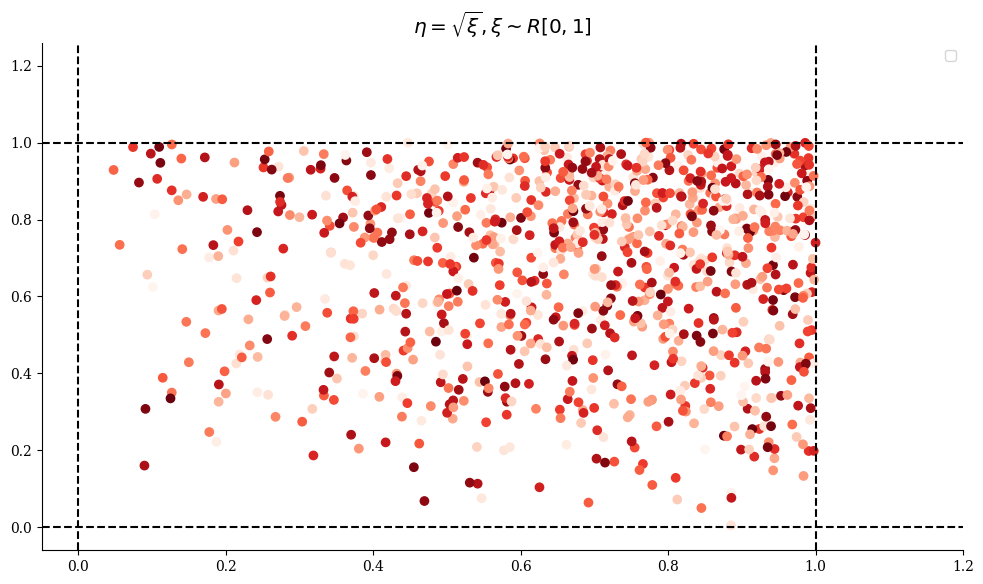

In [1421]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    step = interval_size/5

    x_values = generateValue(n=EXTRA_SAMPLE_SIZE)
    y_values = generateValue(n=EXTRA_SAMPLE_SIZE)

    colors = [sp.stats.uniform.rvs(0, 100) for _ in range(EXTRA_SAMPLE_SIZE)]

    plotTitle = ''
    match A_:
        case 1:
            plotTitle = '$\\eta = \\sqrt{\\xi}, \\xi \\sim R[0, 1]$'
        case 2:
            plotTitle = '$1 - \\eta = \\sqrt{\\xi}, \\xi \\sim R[0, 1]$'

    ax.scatter(x_values, 
               y_values, 
               c=colors, 
               cmap='Reds',
               label='')
    
    ax.axvline(x=b_, color='black', linestyle='--')
    ax.axhline(y=b_, color='black', linestyle='--')

    ax.axvline(x=a_, color='black', linestyle='--')
    ax.axhline(y=a_, color='black', linestyle='--')

    ax.axhline(y=b_ + step, color='white', linestyle='--')

    ax.set_title(plotTitle)

    decorate_plot(ax, np.arange(a_, b_ + step + step, step), '', '', loc='best')
    
    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modifed_uniform_EXTRA_SAMPLE_SIZE')

In [1422]:
def g(x):
    match A_:
        case 1:
            return np.sqrt(x)
        case 2:
            return 1 - np.sqrt(x)
        case _:
            raise ValueError("Invalid value for A")

def inverseFunction(y):
    def equation_to_solve(x):
            return g(x) - y

    sol = None
    guesses = np.arange(a_, b_ + (b_ - a_)/10, (b_ - a_)/10)
    for guess in guesses:
        try: 
            sol, = sp.optimize.fsolve(equation_to_solve, guess)
            break
        except:
            continue
    
    if sol is not None: 
        return sol
    else: 
        raise Exception('solution was not found')

In [1423]:
def pdf_(x):
    if x < a_ or x > b_:
        return 0

    def numericalDerivative(f, x):
         return cdm_.diff(f=f, x=x)
    
    inverse_x = inverseFunction(x)
    if A_ == 2: # ???
        return np.abs(1/numericalDerivative(g, inverse_x) * sp.stats.uniform.pdf(inverse_x))
    else:
        return 1 / numericalDerivative(g, inverse_x) * sp.stats.uniform.pdf(inverse_x)

In [1424]:
def pdf_actual(x):
    if (x < 0):       return 0
    if (0 <= x <= 1): return 2*x
    if (x > 1):       return 0

In [1425]:
# def pdf_actual(x): 
#     if (x < 0):       return 0
#     if (0 <= x <= 1): return 2 - 2*x
#     if (x > 1):       return 0

In [1426]:
# x_s = np.arange(-1, 2, 0.1)

# for x in x_s:
#     print(f'mine:{pdf_(x)}     actual:{pdf_actual(x)}')

In [1427]:
def cdf_(x):
    if A_ == 2: # ???
        return 1 - sp.stats.uniform.cdf(inverseFunction(x))
    else:
        return sp.stats.uniform.cdf(inverseFunction(x))

In [1428]:
def cdf_actual(x):
    if (x < 0):       return 0
    if (0 <= x <= 1): return x**2
    if (x > 1):       return 1

In [1429]:
# def cdf_actual(x): 
#     if (x < 0):       return 0
#     if (0 <= x <= 1): return 2*x - x**2
#     if (x > 1):       return 1

In [1430]:
# x_s = np.arange(-1, 2, 0.1)

# for x in x_s:
#     print(f'mine:{cdf_(x)}     actual:{cdf_actual(x)}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


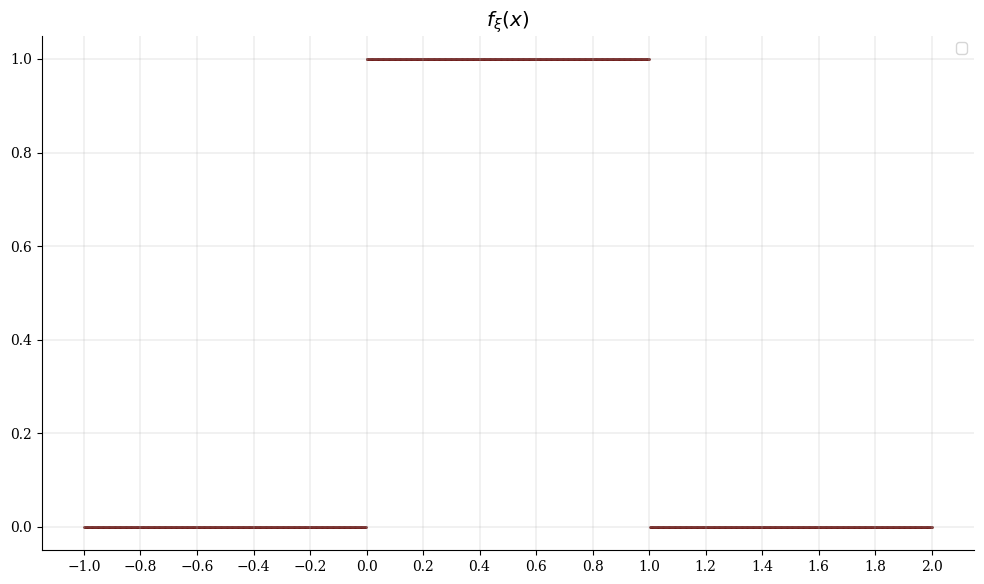

In [1431]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = sp.stats.uniform.pdf(x_values)

    ax.scatter(x_values, 
               y_values, 
               color=RED, 
               label='',
               s=1)

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$f_\\xi(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


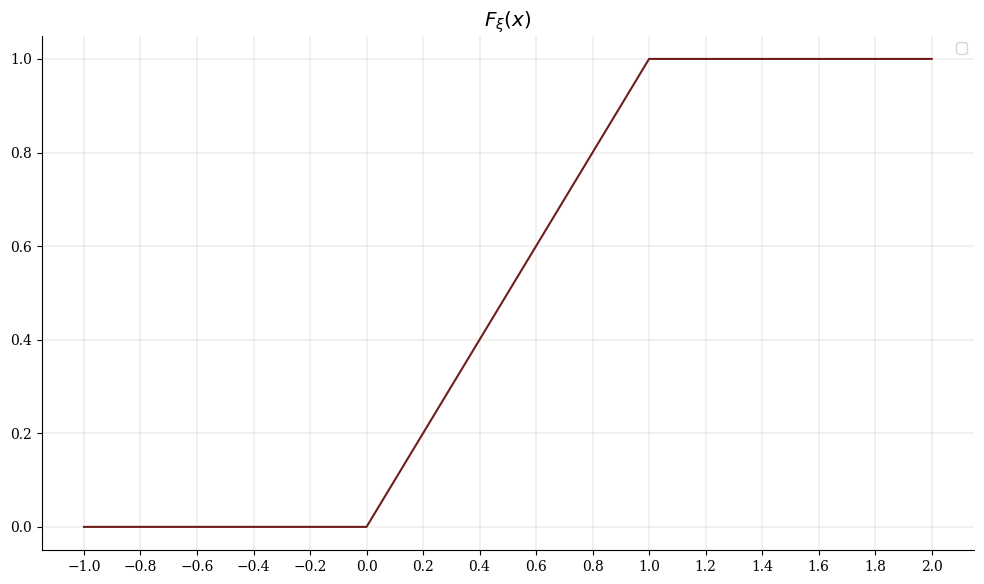

In [1432]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = sp.stats.uniform.cdf(x_values)

    ax.plot(x_values, 
            y_values, 
            color=RED, 
            label='')

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$F_\\xi(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_cdf')

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_2212\346138107.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


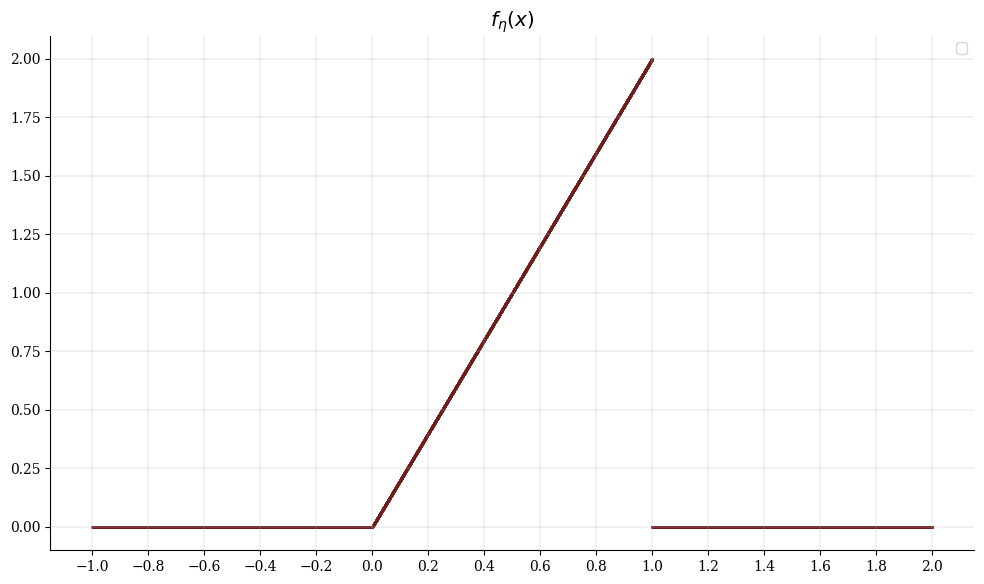

In [1433]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5
 
    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE * 10)
    y_values = [pdf_(x) for x in x_values]

    ax.scatter(x_values, 
               y_values, 
               color=RED, 
               label='',
               s=1)

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$f_\\eta(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modified_uniform_pdf')

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_2212\346138107.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
C:\Users\HYPERPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


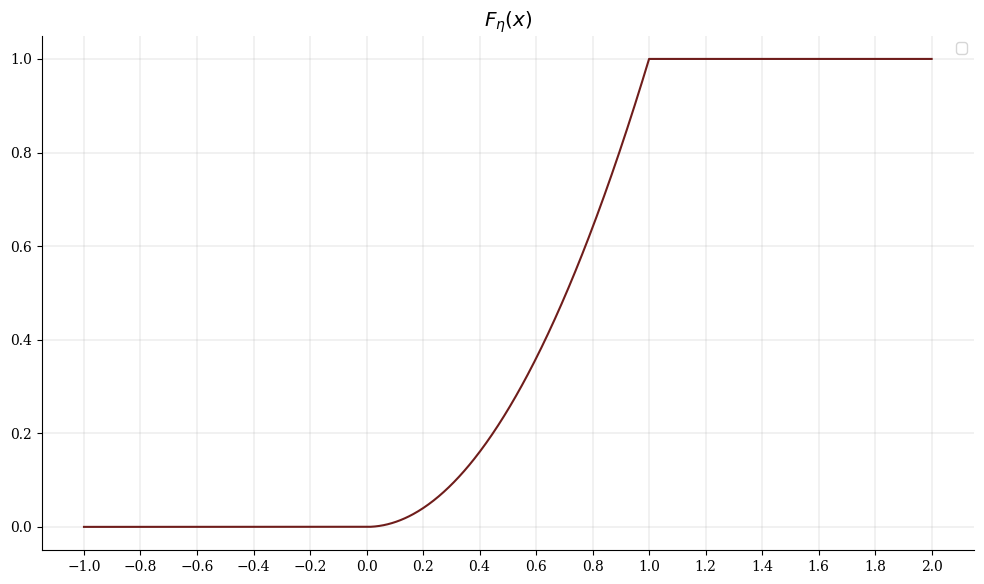

In [1434]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = [cdf_(x) for x in x_values]

    ax.plot(x_values, 
            y_values, 
            color=RED, 
            label='')

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$F_\\eta(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modifed_uniform_cdf')

In [1435]:
data_ = [generateValue(n_) for _ in range(m_)]

In [1436]:
def group(data):
    min_ = min(data)
    max_ = max(data)

    range_ = max_ - min_

    l_ = 1 + int(np.log2(n_))

    h_ = range_ / l_

    int_boundaries_ = np.array(
        [min_ + i * h_ for i in range(0, l_ + 1, 1)]
    )
    intervals_ = np.array(
        [(int_boundaries_[i], int_boundaries_[i+1]) for i in range(0, l_, 1)]
    )
    mid_ranges_ = np.array(
        [sum(interval)/2 for interval in intervals_]
    )

    present = lambda el, int_ : int_[0] <= el < int_[1]
    freqs_ = np.zeros(l_)
    for el in data:
        for j in range(0, l_, 1):
            if present(el, intervals_[j]):
                freqs_[j] += 1 

    freqs_[-1] += np.count_nonzero(data == max_)

    rel_freqs_ = freqs_ / n_

    assert np.abs(np.sum(rel_freqs_) - 1) <= 1e-2

    rel_freqs_density_ = rel_freqs_ / h_
    
    return n_, min_, max_, range_, l_,  h_, int_boundaries_, intervals_, mid_ranges_, freqs_, rel_freqs_, rel_freqs_density_

In [ ]:
groupedSamples = [Sample(*group(sample)) for sample in data_]
print(groupedSamples[0])

n: 1000
min: 0.017970596783053308     max: 0.9995424572927389
range: 0.9815718605096856
l: 10
h: 0.09815718605096856
interval boundaries: [0.0179706  0.11612778 0.21428497 0.31244215 0.41059934 0.50875653
 0.60691371 0.7050709  0.80322809 0.90138527 0.99954246]
intervals: [[0.0179706  0.11612778]
 [0.11612778 0.21428497]
 [0.21428497 0.31244215]
 [0.31244215 0.41059934]
 [0.41059934 0.50875653]
 [0.50875653 0.60691371]
 [0.60691371 0.7050709 ]
 [0.7050709  0.80322809]
 [0.80322809 0.90138527]
 [0.90138527 0.99954246]]
intervals' midpoints: [0.06704919 0.16520638 0.26336356 0.36152075 0.45967793 0.55783512
 0.65599231 0.75414949 0.85230668 0.95046386]
frequencies: [  9.  37.  58.  54.  88. 120. 144. 128. 174. 188.]
relative frequencies: [0.009 0.037 0.058 0.054 0.088 0.12  0.144 0.128 0.174 0.188]
relative frequencies' density: [0.09168967 0.37694642 0.59088898 0.55013802 0.89652122 1.22252893
 1.46703472 1.30403086 1.77266695 1.91529533]
------------------------------------------------